In [1]:
import DirectDmTargets as dddm

calculating effective efficancy for Xe detector done
calculating effective efficancy for Ar detector done
calculating effective efficancy for Ge detector done


In [2]:
import wimprates as wr

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

In [61]:
dddm.detectors['Xe']['res'](1)

<class 'DirectDmTargets.detector.DetectorSpectrum'>


## Detector smearing

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [8]:
use_SHM = dddm.SHM()

In [9]:
def plot_spectrum(data, color = 'blue', label = 'label'):
    plt.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']),
                color = color,
                linestyle = 'none',
                capsize = 2,
                marker = 'o',
                label = label
                )

In [17]:
%%time
xe_events = dddm.GenSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
xe_events.n_bins = 10
xe_galact = xe_events.get_data(poisson = False)
xe_events.n_bins

Wall time: 9.97 ms


10

In [18]:
%%time
xe_events = dddm.DetectorSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
xe_events.n_bins = 10

xe_det = xe_events.get_data(poisson = False)

Wall time: 753 ms


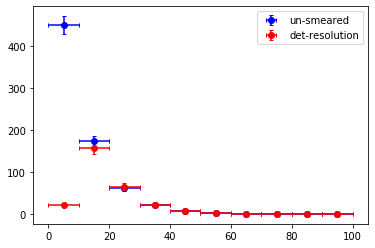

In [19]:
plot_spectrum(xe_galact, label = 'un-smeared')
plot_spectrum(xe_det, 'red', label = 'det-resolution')
# plt.yscale("log")
plt.legend()

In [20]:
from __future__ import print_function
from IPython.core import page
page.page = print

In [21]:
%load_ext line_profiler

In [48]:
test_class = dddm.DetectorSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
test_class.n_bins = 3
test_class.n_bins_result = 15

In [49]:
test = test_class.get_data
%lprun -f test test(poisson = False)

Timer unit: 1e-07 s

Total time: 0.369927 s
File: D:\Google Drive\PhD-master\ubuntu-storage\windows-anaconda\DD_DM_targets\DirectDmTargets\detector.py
Function: get_data at line 218

Line #      Hits         Time  Per Hit   % Time  Line Contents
   218                                               def get_data(self, poisson=True):
   219                                                   """
   220                                           
   221                                                   :param poisson: type bool, add poisson True or False
   222                                                   :return: pd.DataFrame containing events binned in energy
   223                                                   """
   224         1       7726.0   7726.0      0.2          result = pd.DataFrame()
   225         1         11.0     11.0      0.0          if poisson:
   226                                                       result['counts'] = self.get_poisson_events()
   227         

In [50]:
test = test_class.get_events
%lprun -f test test()

Timer unit: 1e-07 s

Total time: 48.8824 s
File: D:\Google Drive\PhD-master\ubuntu-storage\windows-anaconda\DD_DM_targets\DirectDmTargets\detector.py
Function: get_events at line 205

Line #      Hits         Time  Per Hit   % Time  Line Contents
   205                                               def get_events(self):
   206                                                   """
   207                                                   :return: Events (binned)
   208                                                   """
   209         1  488823706.0 488823706.0    100.0          return self.compute_detected_spectrum()


In [51]:
test = test_class.compute_detected_spectrum
test_class.n_bins = 10
test_class.n_bins_result = 100
%lprun -f test test()

Timer unit: 1e-07 s

Total time: 1.21853 s
File: D:\Google Drive\PhD-master\ubuntu-storage\windows-anaconda\DD_DM_targets\DirectDmTargets\detector.py
Function: compute_detected_spectrum at line 186

Line #      Hits         Time  Per Hit   % Time  Line Contents
   186                                               def compute_detected_spectrum(self):
   187                                                   # assert self.n_bins / self.n_bins_result > 5, "binning to course for numerical integration"
   188                                           
   189         1         21.0     21.0      0.0          self.n_bins_result = self.n_bins
   190         1         11.0     11.0      0.0          self.n_bins = self.n_bins * 100
   191         1   12034801.0 12034801.0     98.8          rates = self.spectrum_simple([self.mw, self.sigma_nucleon])
   192         1       8669.0   8669.0      0.1          energies = self.get_bin_centers()
   193         1        180.0    180.0      0.0          ra

In [52]:
test = test_class.spectrum_simple
test_class.n_bins = 10
test_class.n_bins_result = 100
%lprun -f test test([50, 1e-45])

Timer unit: 1e-07 s

Total time: 0.0128628 s
File: D:\Google Drive\PhD-master\ubuntu-storage\windows-anaconda\DD_DM_targets\DirectDmTargets\halo.py
Function: spectrum_simple at line 89

Line #      Hits         Time  Per Hit   % Time  Line Contents
    89                                               def spectrum_simple(self, benchmark):
    90                                                   """
    91                                                   :param benchmark: insert the kind of DM to consider (should contain Mass and Crossection)
    92                                                   :return: returns the rate
    93                                                   """
    94         1         17.0     17.0      0.0          if (not type(benchmark) == dict) or (not type(benchmark) == pd.DataFrame):
    95         1          6.0      6.0      0.0              benchmark = {'mw': benchmark[0],
    96         1          7.0      7.0      0.0                           'sigma_n

In [58]:
test_2 = wr.rate_wimp_std
%lprun -f test_2 test_2(np.linspace(1,100,10), 50, 1e-45)

Timer unit: 1e-07 s

Total time: 0.0120497 s
File: d:\google drive\phd-master\ubuntu-storage\windows-anaconda\wimprates\wimprates\summary.py
Function: rate_wimp_std at line 58

Line #      Hits         Time  Per Hit   % Time  Line Contents
    58                                           @export
    59                                           def rate_wimp_std(es, mw, sigma_nucleon, m_med=float('inf'),
    60                                                             t=None, halo_model=None, **kwargs):
    61                                               """Differential rate per (ton year keV) of WIMP-nucleus scattering.
    62                                               :param es: Recoil energies in keV
    63                                               :param mw: WIMP mass in GeV/c^2
    64                                               :param sigma_nucleon: WIMP-nucleon cross-section in cm^2
    65                                               :param m_med: Medator mass in GeV/

In [59]:
test_2 = wr.rate_wimp
%lprun -f test_2 test_2(np.linspace(1,100,10), 50, 1e-45)

Timer unit: 1e-07 s

Total time: 0.000151 s
File: d:\google drive\phd-master\ubuntu-storage\windows-anaconda\wimprates\wimprates\summary.py
Function: rate_wimp at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           @export
    11                                           def rate_wimp(es, mw, sigma_nucleon, interaction='SI',
    12                                                         detection_mechanism='elastic_nr', m_med=float('inf'),
    13                                                         t=None, halo_model=None,
    14                                                         **kwargs):
    15                                               """Differential rate per unit time, unit detector mass
    16                                               and unit recoil energy of WIMP-nucleus scattering.
    17                                               Use numericalunits to get variables in/out in the right unit